# Testing ClusterDE - Optimized null data

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_32547/2862039534.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


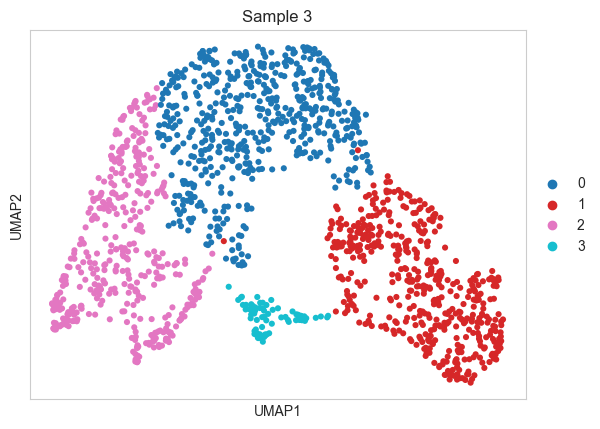

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

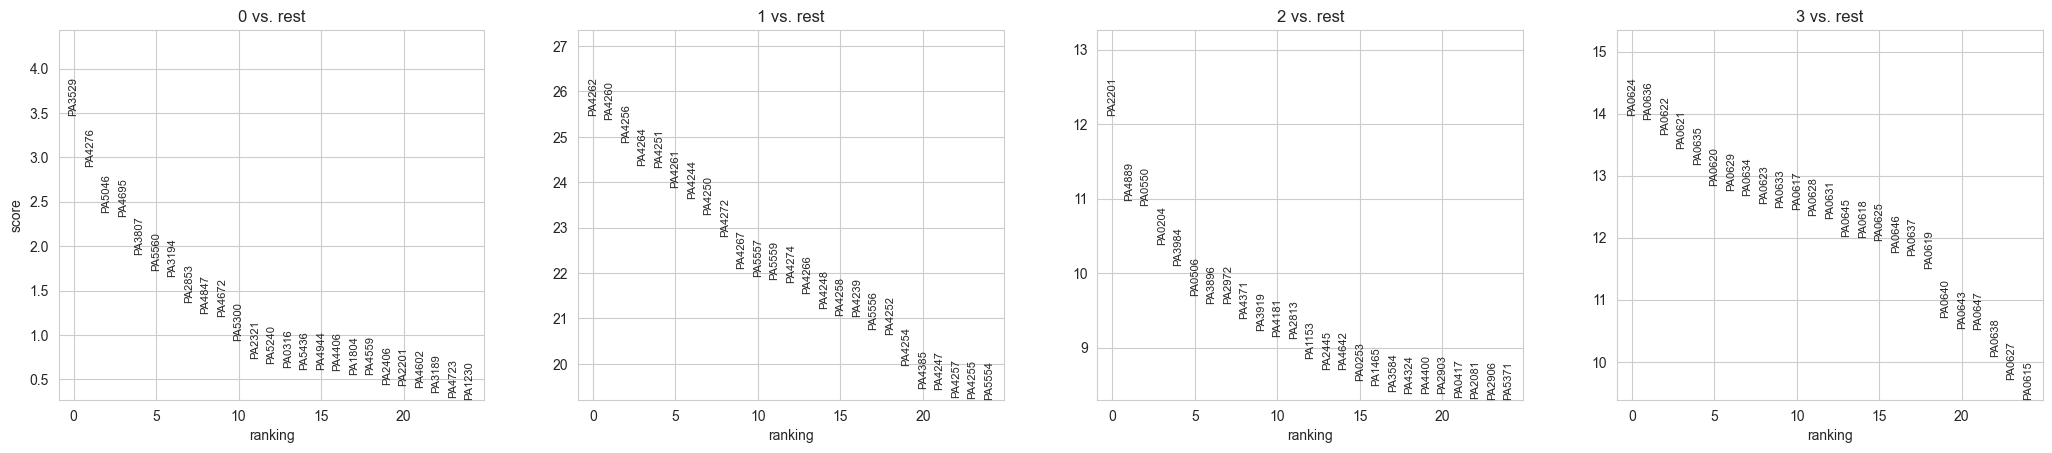

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

### Load and process null data

In [19]:
data_null_gen = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/null_data_opt_cor_scale.h5ad")

In [20]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

gene 0
gene 100
gene 200
gene 300
gene 400
gene 500
gene 600
gene 700
gene 800
gene 900
gene 1000
gene 1100
gene 1200
gene 1300
gene 1400
gene 1500
gene 1600
gene 1700
gene 1800
gene 1900
gene 2000
gene 2100
gene 2200
gene 2300
gene 2400
gene 2500
gene 2600
gene 2700
gene 2800
gene 2900
gene 3000
gene 3100
gene 3200
gene 3300
gene 3400
gene 3500
gene 3600
gene 3700
gene 3800
gene 3900
gene 4000
gene 4100
gene 4200
gene 4300
gene 4400
gene 4500
gene 4600
gene 4700
gene 4800
gene 4900
gene 5000
gene 5100
gene 5200
gene 5300
gene 5400
gene 5500


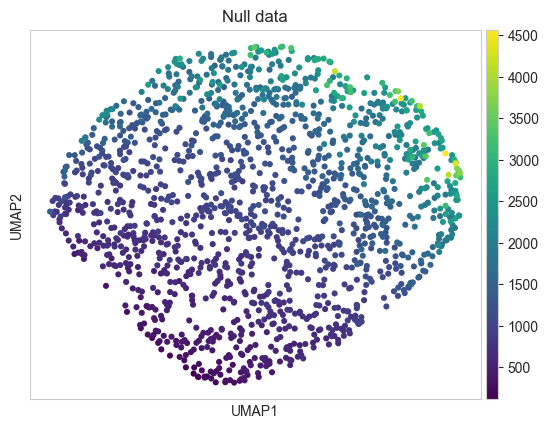

In [21]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="statsmod_auto")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["est_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [22]:
print(data_null_gen.var["gene_dist"].value_counts())
print(data_gene.var["gene_dist"].value_counts())


gene_dist
nb     5138
poi     415
Name: count, dtype: int64
gene_dist
nb     5144
poi     409
Name: count, dtype: int64


In [84]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

Resolution for two clusters: 0.09999999999999999


In [85]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()


In [92]:
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.9825
Cluster 1 - DE genes: 49; Minimum q value: 0.03333333333333333
Cluster 2 - DE genes: 48; Minimum q value: 0.038461538461538464
Cluster 3 - DE genes: 0; Minimum q value: 0.25


In [93]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.20253164556962025
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 0; Minimum q value: 0.054213317619328225
Cluster 3 - DE genes: 0; Minimum q value: 1.0


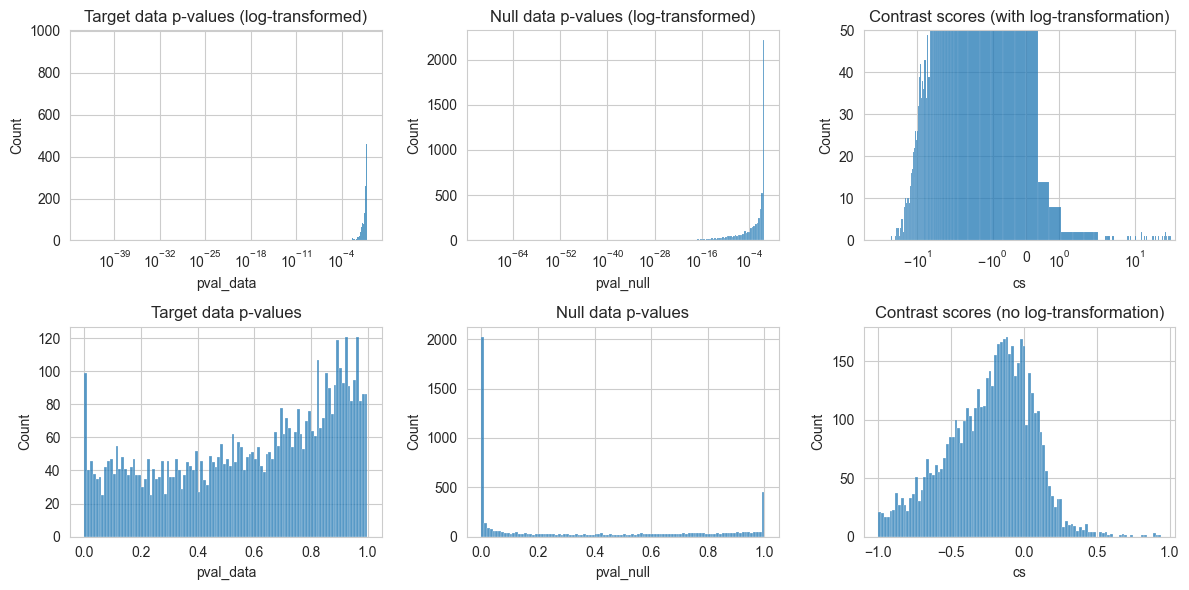

In [101]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

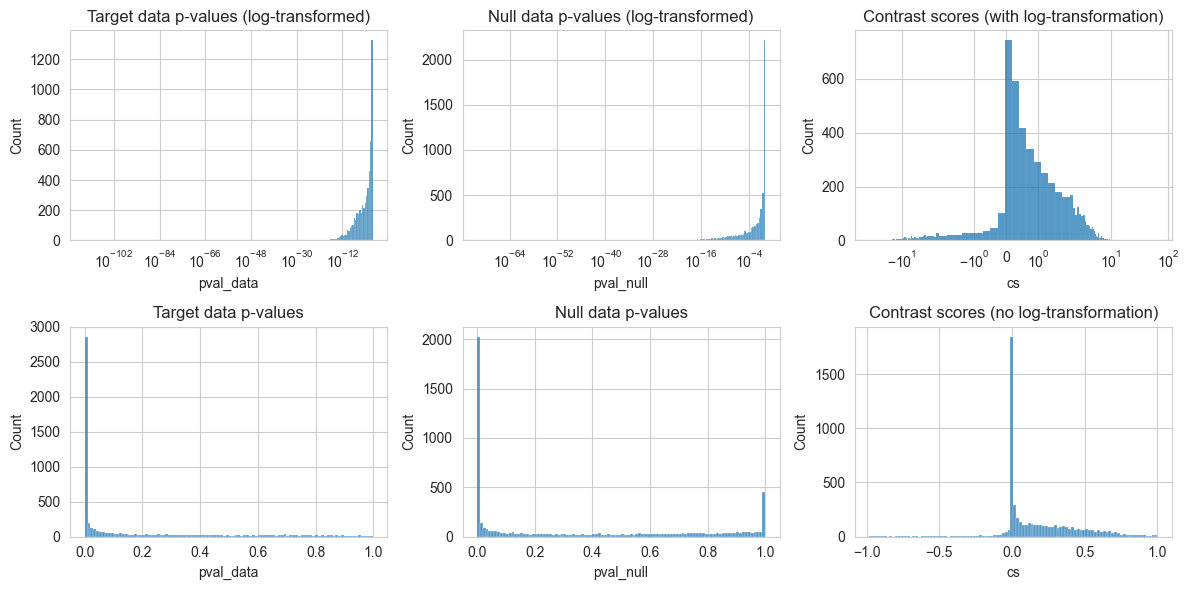

In [95]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [96]:
pvals_gen["2"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA0869,3.221826e-11,1.000000e+00,3.221826e-11,1.000000e+00,1.000000,0.054213
PA0045,1.644316e-07,1.000000e+00,1.644316e-07,1.000000e+00,1.000000,0.054213
PA0926,4.962853e-07,1.000000e+00,4.962853e-07,1.000000e+00,1.000000,0.054213
PA4831,7.611215e-07,1.000000e+00,7.611215e-07,1.000000e+00,0.999999,0.054213
PA3935,4.661679e-06,1.000000e+00,4.661679e-06,1.000000e+00,0.999995,0.054213
...,...,...,...,...,...,...
PA1767,9.296744e-01,2.898351e-09,9.296744e-01,2.898351e-09,-0.929674,1.000000
PA3644,9.316670e-01,1.834789e-12,9.316670e-01,1.834789e-12,-0.931667,1.000000
PA3806,9.453709e-01,2.420742e-10,9.453709e-01,2.420742e-10,-0.945371,1.000000


In [102]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA0636,6.161842e-44,3.302838e-02,43.210289,1.481113,41.729177,0.25
PA0622,1.946223e-42,2.182819e-02,41.710807,1.660982,40.049825,0.25
PA0624,2.354790e-44,9.053055e-05,43.628048,4.043205,39.584843,0.25
PA0621,4.073517e-41,1.895977e-03,40.390030,2.722167,37.667863,0.25
PA0635,1.254658e-39,2.739059e-03,38.901475,2.562399,36.339076,0.25
...,...,...,...,...,...,...
PA1074,2.382140e-01,1.081838e-28,0.623033,27.965838,-27.342805,1.00
PA5049,4.892274e-01,9.830930e-31,0.310489,30.007405,-29.696916,1.00
PA4672,7.288135e-01,2.717943e-34,0.137384,33.565760,-33.428376,1.00


<Axes: xlabel='cs', ylabel='cs'>

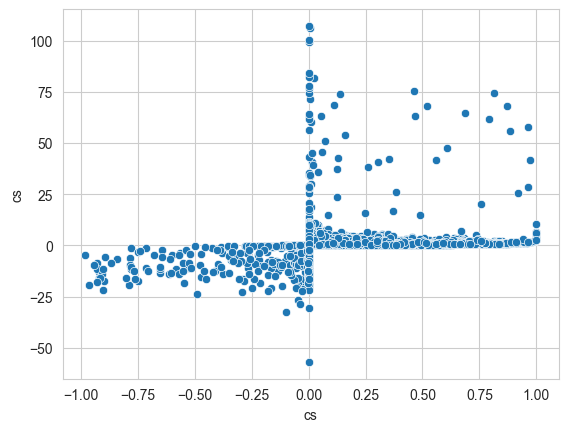

In [98]:
sns.scatterplot(x = pvals_gen["2"]["cs"], y = pvals_log_gen["2"]["cs"])

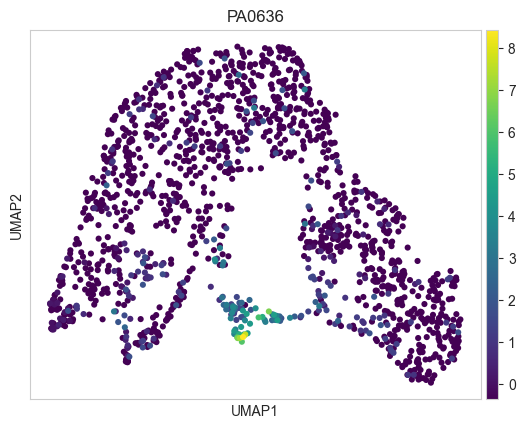

In [111]:
sc.pl.umap(data_gene, color=pvals_log_gen["3"].sort_values("q", ascending=True).index.tolist()[:1], cmap="viridis")


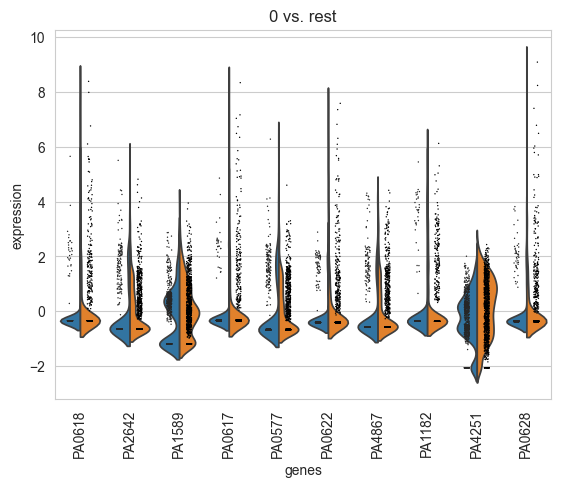

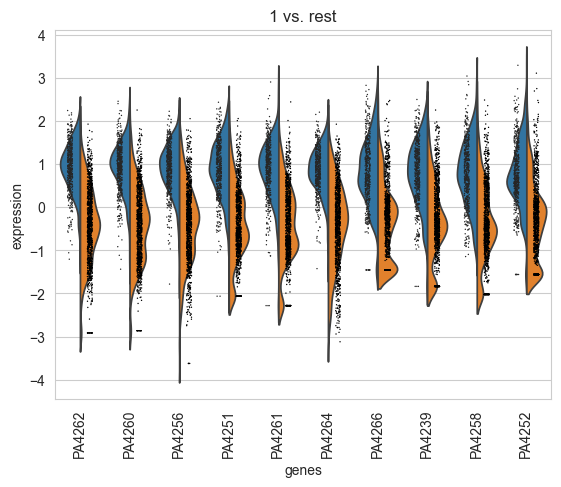

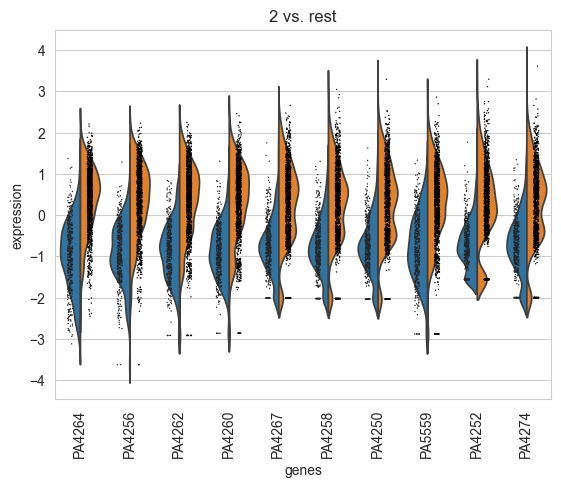

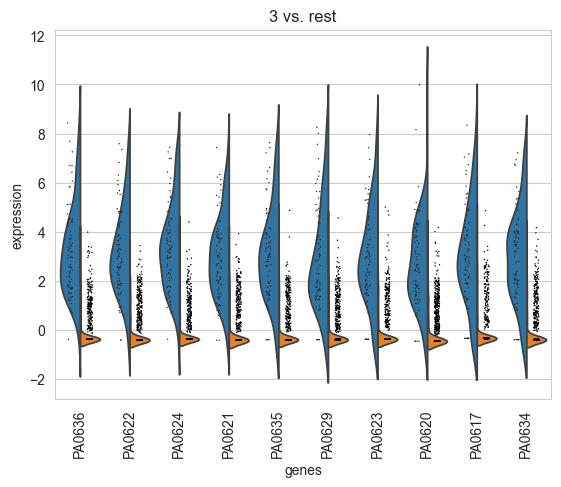

In [113]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), gene_names=pvals_log_gen[str(i)].sort_values("q", ascending=True).index.tolist()[:10])

In [115]:
pvals_log_gen["3"].to_csv("pvals_3.csv")